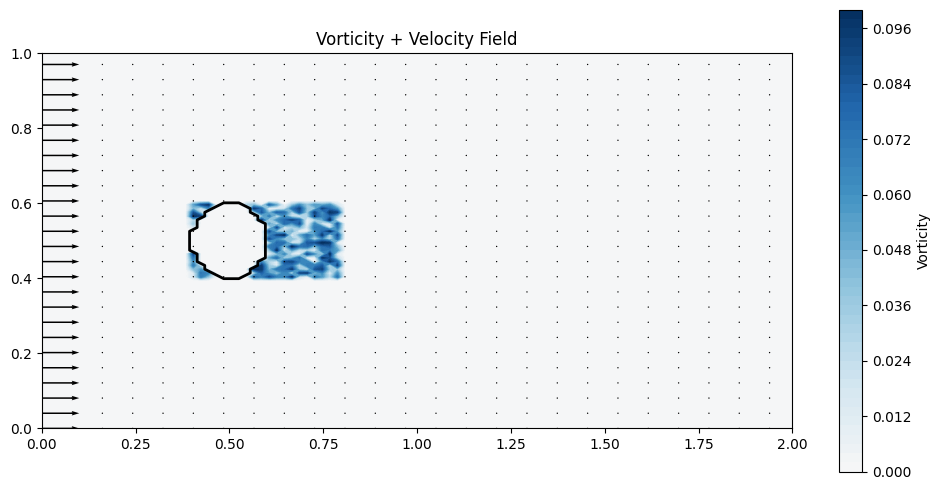

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Grid and Parameters

nx, ny = 100, 100
Lx, Ly = 2.0, 1.0
dx, dy = Lx / (nx - 1), Ly / (ny - 1)
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

cx, cy, radius = 0.5, 0.5, 0.1
cylinder = (X - cx)**2 + (Y - cy)**2 < radius**2

nu = 0.0001       # Kinematic viscosity
dt = 0.001
nt = 1000        
save_every = 5    # Save every 5 frames

# Initial fields 

omega = np.zeros((ny, nx))
psi = np.zeros((ny, nx))

# Adding some initial perturbation to create vortices

omega[40:60, 20:40] = 0.1 * np.random.rand(20, 20)

# Poisson Solver (Jacobi)

def solve_poisson_jacobi(psi, omega, dx, dy, cylinder, max_iter=5000, tol=1e-5):
    for _ in range(max_iter):
        psi_old = psi.copy()
        psi[1:-1, 1:-1] = 0.25 * (
            psi_old[1:-1, 2:] + psi_old[1:-1, :-2] +
            psi_old[2:, 1:-1] + psi_old[:-2, 1:-1] +
            dx**2 * (-omega[1:-1, 1:-1]))
        psi[0, :] = psi[-1, :] = psi[:, 0] = psi[:, -1] = 0
        psi[cylinder] = 0
        if np.linalg.norm(psi - psi_old, ord=np.inf) < tol:
            break
    return psi

# Velocity from streamfunction 

def compute_velocity(psi, dx, dy):
    u = np.zeros_like(psi)
    v = np.zeros_like(psi)
    u[1:-1, 1:-1] = (psi[2:, 1:-1] - psi[:-2, 1:-1]) / (2 * dy)
    v[1:-1, 1:-1] = -(psi[1:-1, 2:] - psi[1:-1, :-2]) / (2 * dx)
    u[:, 0] = 1.0  # constant horizontal velocity
    u[cylinder] = 0
    v[cylinder] = 0
    return u, v

# Time-stepping and collecting frames 

frames = []
u_frames = []
v_frames = []
for n in range(nt):
    psi = solve_poisson_jacobi(psi, omega, dx, dy, cylinder)
    u, v = compute_velocity(psi, dx, dy)
    u[:, 0] = 1.0  # uniform horizontal inflow
    v[:, 0] = 0.0
    psi[:, 0] = psi[:, 1]

    # Advection and diffusion of vorticity
    
    d_omega_dx = (omega[1:-1, 2:] - omega[1:-1, :-2]) / (2 * dx)
    d_omega_dy = (omega[2:, 1:-1] - omega[:-2, 1:-1]) / (2 * dy)
    laplacian = (
        (omega[1:-1, 2:] - 2 * omega[1:-1, 1:-1] + omega[1:-1, :-2]) / dx**2 +
        (omega[2:, 1:-1] - 2 * omega[1:-1, 1:-1] + omega[:-2, 1:-1]) / dy**2
    )

    omega[1:-1, 1:-1] += dt * (
        -u[1:-1, 1:-1] * d_omega_dx
        -v[1:-1, 1:-1] * d_omega_dy
        + nu * laplacian
    )

    # Boundary conditions
    
    omega[0, :] = omega[-1, :] = omega[:, 0] = omega[:, -1] = 0
    omega[cylinder] = 0

    if n % save_every == 0:  # Save frame periodically
        frames.append(omega.copy())
        u_frames.append(u.copy())
        v_frames.append(v.copy())

# Animation 

fig, ax = plt.subplots(figsize=(10, 5))

vmax = np.max(np.abs(frames[0]))
vmin = -vmax

contour = ax.contourf(X, Y, frames[0], levels=50, cmap='RdBu', vmin=vmin, vmax=vmax)
cylinder_plot = ax.contour(X, Y, cylinder, colors='black', linewidths=2)
quiv = ax.quiver(X[::4, ::4], Y[::4, ::4], 
                u_frames[0][::4, ::4], v_frames[0][::4, ::4], 
                color='k', scale=20, width=0.002)
plt.colorbar(contour, ax=ax, label='Vorticity')
ax.set_title("Vorticity + Velocity Field")
ax.set_aspect('equal')

def update(i):
    ax.clear()
    vmax = np.max(np.abs(frames[i]))
    vmin = -vmax
    ax.contourf(X, Y, frames[i], levels=50, cmap='RdBu', vmin=vmin, vmax=vmax)
    ax.contour(X, Y, cylinder, colors='black', linewidths=2)
    ax.quiver(X[::4, ::4], Y[::4, ::4], 
              u_frames[i][::4, ::4], v_frames[i][::4, ::4], 
              color='k', scale=20, width=0.002)
    ax.set_title(f"Vorticity at frame {i}")
    ax.set_aspect('equal')
    return []

anim = animation.FuncAnimation(fig, update, frames=len(frames), interval=50, blit=False)
plt.tight_layout()
plt.show()

mp4_filename = "vortex__simulation.mp4"
writer = animation.FFMpegWriter(fps=15, bitrate=1800)  
anim.save(mp4_filename, writer=writer)